In [1]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
import seaborn as sns
import plotly.express as px

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data from csv file
vgsales = pd.read_csv("/Users/jerryy/PycharmProjects/MATH3017/Project/Video_Games_Sales_as_at_22_Dec_2016.csv")

In [3]:
# drop the few null values
vgsales.dropna(inplace=True)

# display the new number of row
vgsales.shape[0]

6825

In [4]:
# convert Year_of_Release from float to int
vgsales['Year_of_Release']=vgsales['Year_of_Release'].astype(int)

# convert User_Score from object to float
vgsales['User_Score']=vgsales['User_Score'].astype(float)

## Classification of Sales category

In [5]:
vgClassification = vgsales[['Genre','Platform','Publisher','Year_of_Release','Global_Sales']]

In [6]:
print(vgClassification.columns)


Index(['Genre', 'Platform', 'Publisher', 'Year_of_Release', 'Global_Sales'], dtype='object')


In [7]:
# Compute the conditions under which titles having "Global Sales" within a certain range will be labelled from 0 to 3.
conditions = [
    vgClassification["Global_Sales"] <= 10,
    (vgClassification["Global_Sales"] > 10) & (vgClassification["Global_Sales"] <= 20),
    (vgClassification["Global_Sales"] > 20) & (vgClassification["Global_Sales"] <= 30),
    (vgClassification["Global_Sales"] > 30) & (vgClassification["Global_Sales"] <= 40),
]

values = [0,1,2,3]
vgClassification["Sales_category"] = np.select(conditions, values)
vgClassification.drop("Global_Sales", axis = 1, inplace = True)

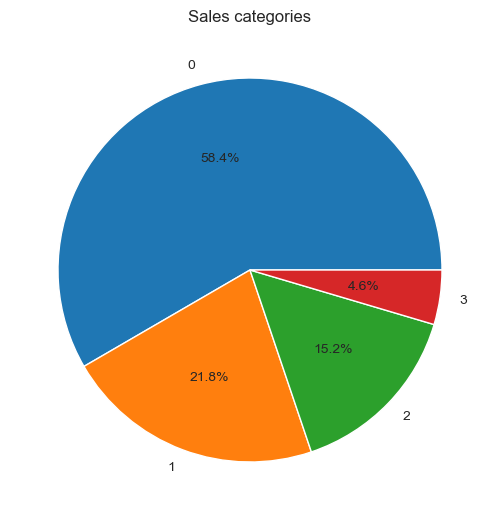

In [8]:
# Show the distribution of "Sales category" on log scale with the new classes
colors1 = ["red","green","blue",'yellow']
series = vgClassification["Sales_category"].value_counts()
series_sorted = series.sort_index()
fig = plt.figure()
Sales_category = ["0","1","2",'3']
ax = fig.add_axes([0,0,1,1])
ax.pie(np.log(series_sorted),labels = Sales_category,autopct='%1.1f%%')
ax.set_title("Sales categories")
plt.show()

In [9]:
# Use the Random Over Sampler to balance the classes
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# one-hot encoding 
vgClassification = pd.concat([pd.get_dummies(vgClassification[['Genre','Platform','Publisher']]),vgClassification[['Year_of_Release','Sales_category']]],axis = 1)

X = vgClassification.drop("Sales_category", axis = 1)
y = vgClassification["Sales_category"]
print('Original dataset shape %s' % Counter(y))
ros = RandomOverSampler(random_state= 42)
X_res, y_res = ros.fit_resample(X, y)
X_new = pd.concat([X_res,y_res],axis = 1)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 6786, 1: 27, 2: 10, 3: 2})
Resampled dataset shape Counter({0: 6786, 3: 6786, 2: 6786, 1: 6786})


### Random Forest Classifier

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.9716454565751284


In [11]:
# Relationship between the accuracy of the random forest algorithm and the number of trees (Ntree)
n_trees = range(1, 13, 1)

# Lists to store results
accuracy_scores = []

# Loop over the range of number of trees
for n_tree in n_trees:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)
    # Create and train the Random Forest model
    model = RandomForestClassifier(n_estimators=n_tree, random_state=42)
    model.fit(X_train, y_train)
    # Predict and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

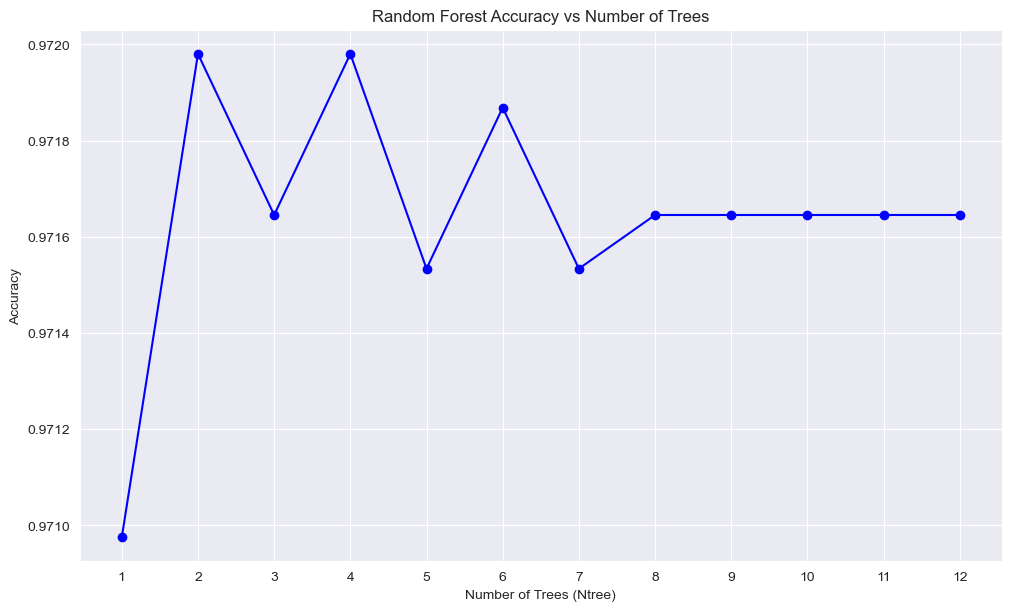

In [12]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_trees, accuracy_scores, marker='o', linestyle='-', color='blue')
plt.title('Random Forest Accuracy vs Number of Trees')
plt.xlabel('Number of Trees (Ntree)')
plt.ylabel('Accuracy')
plt.xticks(list(n_trees))
plt.grid(True)
plt.show()

### Feature Importance

In [13]:
featureImp= []
for feat, importance in zip(X_train.columns, model.feature_importances_):  
    temp = [feat, importance*100]
    featureImp.append(temp)

fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])

idxs = fT_df.sort_values('Importance', ascending = False).index[:10]
print (fT_df.sort_values('Importance', ascending = False))

                                        Feature  Importance
291                             Year_of_Release   19.723921
24                                 Platform_Wii   13.608533
189                          Publisher_Nintendo    8.683138
3                                    Genre_Misc    4.869747
8                                 Genre_Shooter    4.533295
..                                          ...         ...
193                         Publisher_NovaLogic    0.000000
69   Publisher_Cloud Imperium Games Corporation    0.000000
191                           Publisher_Nobilis    0.000000
71                 Publisher_Codemasters Online    0.000000
99                    Publisher_Fox Interactive    0.000000

[292 rows x 2 columns]


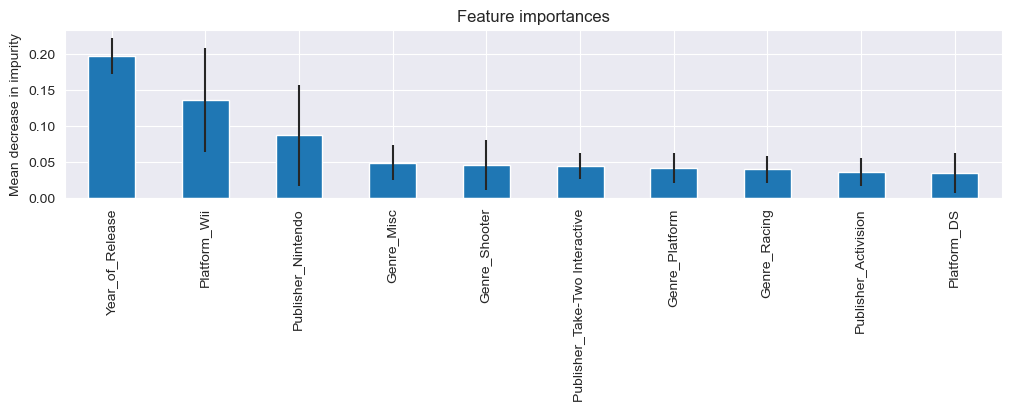

In [14]:
# Plot the feature importances
feature_names = [f"{i}" for i in vgClassification.columns[:-1]]
forest_importances = pd.Series(model.feature_importances_, index=feature_names)
best_feat_importances = forest_importances.sort_values(ascending=False)[:10]

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
best_feat_importances.plot.bar(yerr=std[idxs],figsize = (10,4))
plt.title("Feature importances")
plt.ylabel("Mean decrease in impurity")
plt.show()